plot data by domainHMM

In [53]:
# python modules
import sys
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [54]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [55]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [56]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}

agent_charge = {'sp':'4+',
                'spd':'3+',
                'CoH':'3+',
                'PEG':'',
                'Ca':'2+',
                'Mg':'2+',
                'HP1a':'',
                'HP1bSUV':'',
                'LKH':'',
                'Ki67':'',
                'FUS':''}

agent_symbol = {'sp':'sp$^{4+}$',
                'spd':'spd$^{3+}$',
                'CoH':'CoH$^{3+}$',
                'PEG':'PEG',
                'Ca':'Ca$^{2+}$',
                'Mg':'Mg$^{2+}$',
                'HP1a':'HP1$\\alpha$',
                'HP1bSUV':'HP1$\\beta$\n+tSUV'}

In [57]:
### domain HMM information
# domain HMM files
domain_path = './data/domain_files/'
domain_HMMfname = {"SPAD (NSpeckle)":"SPAD_Gaussian_2.bed",
                   "NAD (Nucleolus)":"NAD_Gaussian_2.bed",
                   "LAD (Lamin)":"LAD_Gaussian_2.bed",
                   "ChromHMM":"H1_12_segments.bed"}

# set domain HMM state name
domain_state_name = {"SPAD (NSpeckle)":{'E1':'SPAD',
                                        'E2':0},
                     "NAD (Nucleolus)":{'E1':0,
                                        'E2':'NAD'},
                     "LAD (Lamin)":{'E1':0,
                                    'E2':'LAD'}
                     }

domain_state_name['ChromHMM'] = {"E1":0,
                                 "E2":"Promoter/Enhancer",
                                 "E3":"Promoter/Enhancer",
                                 "E4":"Promoter/Enhancer",
                                 "E5":"Promoter/Enhancer",
                                 "E6":"Promoter/Enhancer",
                                 "E7":0,
                                 "E8":0,
                                 "E9":"H3K9me3 enriched",
                                 "E10":"Tx elongation",
                                 "E11":"Tx elongation",
                                 "E12":0}

domains =['ChromHMM', "SPAD (NSpeckle)", "NAD (Nucleolus)", "LAD (Lamin)"]

In [58]:
### set target cell and target chromosomes
cell = 'H1'
chr_choices = cell_chrnames['H1']

In [59]:
### load gtab files
gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dinfo_dkey = {'H1_NCP_sp_1rep_deep_1kb_zscore.gtab.gz':
              {'H1_NCP_sp_8_1rep_deep':(1, 'H1', 'NCP', 'sp', 8)},
              'H1_NCP_HP1a_1rep_deep_1kb_zscore.gtab.gz':
              {'H1_NCP_HP1a_3_1rep_deep':(1, 'H1', 'NCP', 'HP1a', 3)}}

dkey_chr_ID_value = load_file.read_gtab_batch (dinfo_dkey,
                                               data_path=gtab_path,
                                               chr_choices=chr_choices,
                                               by_chr=True)

dkey_list = [(1, 'H1', 'NCP', 'sp', 8),
             (1, 'H1', 'NCP', 'HP1a', 3)]


loading H1_NCP_sp_1rep_deep_1kb_zscore.gtab.gz


loading H1_NCP_HP1a_1rep_deep_1kb_zscore.gtab.gz


Done


In [60]:
### load domainHMM files
domain_chr_state_intervals = {}
for domain in domains:
    chr_state_intervals = load_file.read_chromHMM(domain_path + domain_HMMfname[domain],
                                                  state_name=domain_state_name[domain],
                                                  chr_choices=chr_choices)
    domain_chr_state_intervals[domain] = chr_state_intervals

In [61]:
### find common target IDs
chr_target_IDs = {}
for chr in chr_choices:
    target_IDs = set([])
    for i in range(len(dkey_list)):
        dkey = dkey_list[i]
        IDs = set(dkey_chr_ID_value[dkey][chr].keys())
        if i == 0:
            target_IDs |= IDs
        else:
            target_IDs &= IDs
    chr_target_IDs[chr] = sorted(list(target_IDs))

In [62]:
### categorize by combined domainHMM
ID_states = {}
for i in range(len(domains)):
    domain = domains[i]
    print domain
    state_IDs = {}
    chr_state_intervals = domain_chr_state_intervals[domain]
    for chr in chr_target_IDs:
        ID_interval = {ID:(ID[1], ID[2]) for ID in chr_target_IDs[chr]}
        state_IDs_temp = statis.categorize_rbin (chr_state_intervals[chr],
                                                 bin_size=1000,
                                                 bin_step=1000,
                                                 binID_interval=ID_interval,
                                                 unique=True,
                                                 silent=True)
        find_IDs = set([])
        for state in state_IDs_temp:
            if state not in state_IDs:
                state_IDs[state] = []
            state_IDs[state] +=state_IDs_temp[state]
            find_IDs |= set(state_IDs_temp[state])

        # add missing IDs
        if 0 not in state_IDs:
            state_IDs[0] = []
        state_IDs[0] += list(set(chr_target_IDs[chr]) - set(find_IDs))
        
    for state, IDs in state_IDs.items():
        for ID in IDs:
            if ID not in ID_states:
                ID_states[ID] = []
            ID_states[ID].append(state)

states_IDs = {}
for ID, states in ID_states.items():
    assert len(states) == len(domains)
    states = tuple(states)
    if states not in states_IDs:
        states_IDs[states] = []
    states_IDs[states].append(ID)
    

ChromHMM


SPAD (NSpeckle)


NAD (Nucleolus)


LAD (Lamin)


In [63]:
### sanity check
print len(ID_states)
count = 0
for chr in chr_choices:
    count += len(chr_target_IDs[chr])
print count

2936885
2936885


In [64]:
### get values for each state
dkey_states_values = {}
for dkey in dkey_list:    
    chr_ID_value = dkey_chr_ID_value[dkey]
    states_values = {}
    for states, IDs in states_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if states not in states_values:
            states_values[states] = []
        states_values[states] += values

    dkey_states_values[dkey] = states_values

In [65]:
### get mean value for each state
dkey_states_mvalue = {}
for dkey in dkey_states_values:    
    states_values = dkey_states_values[dkey]
    states_mvalue = {}
    for states, values in states_values.items():
        mvalue = np.mean(values)
        states_mvalue[states] = mvalue
    dkey_states_mvalue[dkey] = states_mvalue

In [66]:
### define target states by descending order of sample-size
size_states = [(len(IDs), states) for states, IDs in states_IDs.items()]
size_states = sorted(size_states, reverse=True)
cutoff = int(size_states[0][0]*0.01)
#cutoff = 0
states_list = []
for size, states in size_states:
    if size > cutoff:
        states_list.append(states)

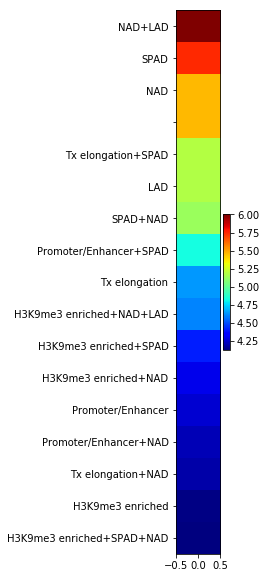

In [67]:
### plot sample size for each states as heatmap
img = []
for states in states_list:
    row = [np.log10(len(states_IDs[states]))]
    img.append(row)

yticklabels = []
for states in states_list:
    label = []
    for state in states:
        if state == 0:
            continue
        label.append(state)
    label = '+'.join(label)
    yticklabels.append(label)

fig = plt.figure(figsize=(1,10))
plt.imshow(img, cmap='jet', aspect='auto')
plt.yticks(range(len(yticklabels)), yticklabels)
plt.colorbar(shrink=0.25)
plt.savefig("./data/" + "domainHMM_size.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()

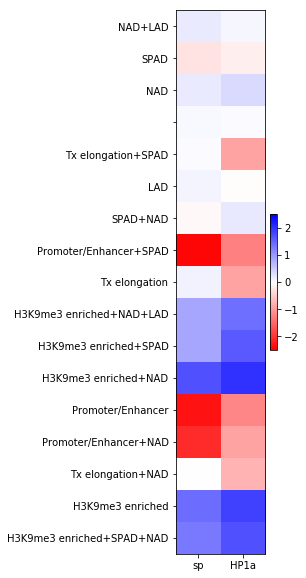

In [68]:
### plot mean value for each states as heatmap [Extended Data Fig.8c]
img = []
for states in states_list:
    row = []
    for dkey in dkey_list:
        mvalue = dkey_states_mvalue[dkey][states]
        row.append(mvalue)
    img.append(row)

xticklabels = [dkey[3] for dkey in dkey_list]

yticklabels = []
for states in states_list:
    label = []
    for state in states:
        if state == 0:
            continue
        label.append(state)
    label = '+'.join(label)
    yticklabels.append(label)

fig = plt.figure(figsize=(2,10))
plt.imshow(img, cmap='bwr_r', vmin=-2.5, vmax=2.5, aspect='auto')
plt.xticks(range(len(xticklabels)), xticklabels)
plt.yticks(range(len(yticklabels)), yticklabels)
plt.colorbar(shrink=0.25)
plt.savefig("./data/" + "domainHMM_mvalue.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()